In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
minhchihoang_finalmlmed_path = kagglehub.dataset_download('minhchihoang/finalmlmed')

print('Data source import complete.')


100%|██████████| 3.25G/3.25G [02:45<00:00, 21.1MB/s]

Extracting files...


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.models import VGG16_BN_Weights

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import cv2
from PIL import Image
import albumentations as A
from pathlib import Path
import seaborn as sns

In [4]:

from typing import TypeVar, Optional
from PIL import Image
import albumentations as A
from pathlib import Path
import seaborn as sns


In [5]:
CATEGORIES: dict[str, int] = {
    "SA": 1,
    "LI": 2,
    "RI": 3,
}
LABELS: dict[int, str] = {v: k for k, v in CATEGORIES.items()}

T = TypeVar("T", bound=np.number)
SampleArg = tuple[T, T] | T

In [6]:
def load_image(path: Path) -> np.ndarray:
    image = Image.open(path)
    image = image.resize((224, 224))  # Resize to the specified size
    return np.array(image)
def load_masks(path: Path) -> tuple[np.ndarray, list[int], list[int]]:
    seg = np.array(Image.open(path))
    return seg_to_masks(seg)
def seg_to_masks(seg: np.ndarray) -> tuple[np.ndarray, list[int], list[int]]:
    """Convert a binary-encoded multi-label segmentation to masks."""
    category_ids = []
    fragment_ids = []
    masks = []
    for category_id in CATEGORIES.values():
        for fragment_id in range(1, 11):
            mask = np.right_shift(seg, _shift(category_id, fragment_id)) & 1
            if mask.sum() > 0:
                masks.append(mask)
                category_ids.append(category_id)
                fragment_ids.append(fragment_id)

    return np.array(masks), category_ids, fragment_ids
def _shift(category_id: int, fragment_id: int) -> int:
    return 10 * (category_id - 1) + fragment_id

def neglog_window(image: np.ndarray, epsilon: float = 0.001) -> np.ndarray:
    """Take the negative log transform of an intensity image.

    Args:
        image (np.ndarray): a single 2D image.
        epsilon (float, optional): positive offset from 0 before taking the logarithm.

    Returns:
        np.ndarray: the image or images after a negative log transform, scaled to [0, 1]
    """
    image = np.array(image)
    shape = image.shape
    if len(shape) == 2:
        image = image[np.newaxis, :, :]

    image_min = image.min(axis=(1, 2), keepdims=True)
    image = image - image_min  # Shift all values to be positive
    image += epsilon
    # negative log transform
    image = -np.log(image)

    # linear interpolate to range [0, 1]
    image_min = image.min(axis=(1, 2), keepdims=True)
    image_max = image.max(axis=(1, 2), keepdims=True)
    if np.any(image_max == image_min):
        print(
            f"mapping constant image to 0. This probably indicates the projector is pointed away from the volume."
        )
        image[:] = 0
        if image.shape[0] > 1:
            print("TODO: zeroed all images, even though only one might be bad.")
    else:
        image = (image - image_min) / (image_max - image_min)

    if np.any(np.isnan(image)):
        print(f"got NaN values from negative log transform.")
        image = np.nan_to_num(image)
    if len(shape) == 2:
        return image[0]
    else:
        return image

def as_float32(image: np.ndarray) -> np.ndarray:
    """Convert the image to float32.

    Args:
        image (np.ndarray): the image to convert.

    Returns:
        np.ndarray: the converted image.
    """
    if image.dtype in [np.float16, np.float32, np.float64]:
        image = image.astype(np.float32)
    elif image.dtype == bool:
        image = image.astype(np.float32)
    elif image.dtype != np.uint8:
        print(f"Unknown image type {image.dtype}. Converting to float32.")
        image = image.astype(np.float32)
    else:
        image = image.astype(np.float32) / 255
    return image

def as_uint8(image: np.ndarray) -> np.ndarray:
    """Convert the image to uint8.

    Args:
        image (np.ndarray): the image to convert.

    Returns:
        np.ndarray: the converted image.
    """
    if image.dtype in [np.float16, np.float32, np.float64]:
        image = np.clip(image * 255, 0, 255).astype(np.uint8)
    elif image.dtype == bool:
        image = image.astype(np.uint8) * 255
    elif image.dtype != np.uint8:
        print(f"Unknown image type {image.dtype}. Converting to uint8.")
        image = image.astype(np.uint8)
    return image

def visualize_drr(image: np.ndarray) -> np.ndarray:
    """Process a raw DRR for visualization.

    Args:
        image (np.ndarray): The raw float32 DRR."""
    # Cast to uint8
    image = neglog_window(image)
    image = as_uint8(image)

    # apply clahe and invert
    clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(8, 8))
    image = clahe.apply(image)
    image = 255 - image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def draw_masks(
    image: np.ndarray,
    masks: np.ndarray,
    alpha: float = 0.3,
    threshold: float = 0.5,
    names = None,
    colors = None,
    palette: str = "hls",
    seed = None,
) -> np.ndarray:
    """Draw contours of masks on an image (copy).

    Args:
        image (np.ndarray): the image to draw on.
        masks (np.ndarray): the masks to draw. [num_masks, H, W] array of masks.
    """

    image = as_float32(image)
    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)

    if colors is None:
        colors = np.array(sns.color_palette(palette, masks.shape[0]))
        if seed is not None:
            np.random.seed(seed)
        colors = colors[np.random.permutation(colors.shape[0])]

    image *= 1 - alpha
    for i, mask in enumerate(masks):
        bool_mask = mask > threshold

        image[bool_mask] = colors[i] * alpha + image[bool_mask] * (1 - alpha)

        contours, _ = cv2.findContours(
            bool_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        image = as_uint8(image)
        cv2.drawContours(image, contours, -1, (255 * colors[i]).tolist(), 1)
        image = as_float32(image)

    image = as_uint8(image)

    fontscale = 0.75 / 512 * image.shape[0]
    thickness = max(int(1 / 256 * image.shape[0]), 1)

    if names is not None:
        for i, mask in enumerate(masks):
            bool_mask = mask > threshold
            ys, xs = np.argwhere(bool_mask).T
            if len(ys) == 0:
                continue
            y = (np.min(ys) + np.max(ys)) / 2
            x = (np.min(xs) + np.max(xs)) / 2
            image = cv2.putText(
                image,
                names[i],
                (int(x) + 5, int(y) - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                fontscale,
                (255 * colors[i]).tolist(),
                thickness,
                cv2.LINE_AA,
            )

    return image

def visualize_sample(image, masks, category_ids, fragment_ids):
    """Visualize the image and masks."""
    names = [
        f"{LABELS[category_id]}-{fragment_id}"
        for category_id, fragment_id in zip(category_ids, fragment_ids)
    ]
    image = visualize_drr(image)
    return draw_masks(image, masks, names=names, seed=0)
def masks_to_seg(masks: np.ndarray, category_ids: list[int], fragment_ids: list[int]) -> np.ndarray:
    """Convert masks to a binary-encoded multi-label segmentation.

    Binarizes the segmentation at each pixel by left shifting the one-hot mask by
    10 * (category_id - 1) + (fragment_id)

    Args:
        masks (np.ndarray): [n, h, w] boolean masks.
        category_ids (list[int]): [n] integer category IDs, in SA (1), LI (2) or RI (3).
        fragment_ids (list[int]): [n] integer fragment IDs, in [1,10].

    Returns:
        np.ndarray: [h, w] uint32 segmentation, where each pixel is a 32-bit integer encoding the
            whether the

    """

    seg = np.zeros((masks.shape[1], masks.shape[2]), dtype=np.uint32)
    masks = masks.astype(np.uint32)
    for mask, category_id, fragment_id in zip(masks, category_ids, fragment_ids):
        seg = np.bitwise_or(seg, np.left_shift(mask, _shift(category_id, fragment_id)))
    return seg

In [8]:
class PENGWIN(Dataset):
    def __init__(self, image_dir , mask_dir):
        self.image_dir =image_dir
        self.mask_dir = mask_dir

        self.image_list = sorted(os.listdir(self.image_dir))
        self.mask_list = sorted(os.listdir(self.mask_dir))

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.image_list[index])
        mask_path = os.path.join(self.mask_dir, self.mask_list[index])

        image = load_image(img_path)
        image = neglog_window(image)
        image = np.repeat(image[..., np.newaxis], 3, axis=-1)
        image = torch.from_numpy(image).float().permute(2, 0, 1)  # Add channel dimension

        # mask = np.array(Image.open(mask_path))
        mask = Image.open(mask_path)
        mask = mask.resize((224, 224), Image.NEAREST)
        mask = np.array(mask)
        masks, category_ids, fragment_ids = seg_to_masks(mask)

        binary_mask = np.zeros((30, 224, 224), dtype=np.float32)
        for mask, cat_id, frag_id in zip(masks, category_ids, fragment_ids):
            channel = (cat_id - 1) * 10 + (frag_id - 1)
            binary_mask[channel] = mask

        binary_mask=torch.from_numpy(binary_mask).to(device)

        return image, binary_mask

In [9]:
image_train_dir = "/root/.cache/kagglehub/datasets/minhchihoang/finalmlmed/versions/1/train/train/Input"
mask_train_dir = "/root/.cache/kagglehub/datasets/minhchihoang/finalmlmed/versions/1/train/train/Output"

image_val_dir = "/root/.cache/kagglehub/datasets/minhchihoang/finalmlmed/versions/1/val/val/Input"
mask_val_dir = "/root/.cache/kagglehub/datasets/minhchihoang/finalmlmed/versions/1/val/val/Output"


train_dataset = PENGWIN(image_train_dir, mask_train_dir)
val_dataset = PENGWIN(image_val_dir, mask_val_dir)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)


In [10]:

print(f"Dataset size: {len(train_dataset)}")

# Test loading one sample
image, masks = train_dataset.__getitem__(1)
print(f"Image shape: {image.shape}")
print(f"Masks shape: {masks.shape}")
batch = next(iter(train_dataloader))
images, masks = batch

print(f"Image shape: {images.shape}")  # (batch_size, C, H, W)
print(f"Mask shape: {masks.shape}")


Dataset size: 3500
Image shape: torch.Size([3, 224, 224])
Masks shape: torch.Size([30, 224, 224])
Image shape: torch.Size([8, 3, 224, 224])
Mask shape: torch.Size([8, 30, 224, 224])


In [11]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


def up_conv(in_channels, out_channels):
    return nn.ConvTranspose2d(
        in_channels, out_channels, kernel_size=2, stride=2
    )


class VGGUnet(nn.Module):
    """Unet VGG-16 (with BN) encoder.
    """

    def __init__(self,out_channels=30):
        super().__init__()

        vgg16_bn = models.vgg16_bn(weights=VGG16_BN_Weights.DEFAULT)  # Use pretrained weights of VGG16-BN
        self.encoder = vgg16_bn.features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = double_conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = double_conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = double_conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = double_conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = double_conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = double_conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGGUnet(out_channels=30).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(f"Model initialized on: {device}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Model initialized on: cuda
Number of parameters: 41897790


In [19]:
def calculate_iou(pred_mask, true_mask):
    # Binarize the prediction and ground truth masks
    pred_mask = (pred_mask > 0.5).float()  # Apply threshold to the predicted mask (logits)
    true_mask = (true_mask > 0.5).float()  # Apply threshold to the ground truth

    intersection = torch.sum(pred_mask * true_mask)  # True Positives (TP)
    union = torch.sum(pred_mask + true_mask) - intersection  # Union (TP + FP + FN)

    iou = intersection / (union + 1e-6)  # Add a small value to avoid division by zero
    return iou


In [20]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    total_iou = 0
    total_samples = 0

    with tqdm(dataloader, desc='Training') as pbar:
        for images, masks in pbar:
            # Move to device
            images = images.to(device)
            masks = masks.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.sigmoid(outputs)  # Apply sigmoid for multi-label segmentation
            preds = (preds > 0.5).float()
            batch_iou = calculate_iou(preds, masks)
            total_iou += batch_iou.item() * images.size(0)  # Sum IoU for all samples in the batch
            total_samples += images.size(0)
            # Backward pass
            loss.backward()
            optimizer.step()

            # Update progress bar
            epoch_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'IoU': f'{total_iou / total_samples:.4f}'})
    avg_iou = total_iou / total_samples
    return epoch_loss / len(dataloader), avg_iou

def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    total_iou = 0
    total_samples = 0

    with torch.no_grad():
        with tqdm(dataloader, desc='Validation') as pbar:
            for images, masks in pbar:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                preds = torch.sigmoid(outputs)  # Apply sigmoid for multi-label segmentation
                preds = (preds > 0.5).float()

                batch_iou = calculate_iou(preds, masks)
                total_iou += batch_iou.item() * images.size(0)  # Sum IoU for all samples in the batch
                total_samples += images.size(0)

                val_loss += loss.item()
                pbar.set_postfix({'loss': f'{loss.item():.4f}', 'IoU': f'{total_iou / total_samples:.4f}'})
    avg_iou = total_iou / total_samples
    return val_loss / len(dataloader), avg_iou


In [21]:
num_epochs = 20
# Training loop
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_ious = []
val_ious = []

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')

    # Train
    train_loss,train_iou = train_epoch(model, train_dataloader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_ious.append(train_iou)
    # Validate
    val_loss,val_iou = validate(model, val_dataloader, criterion, device)
    val_losses.append(val_loss)
    val_ious.append(val_iou)

    print(f'Training Loss: {train_loss:.4f}, Training IoU: {train_iou:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}')
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, 'unet.pth')


Epoch 1/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.5295, Training IoU: 0.0605
Validation Loss: 0.3967, Validation IoU: 0.1179

Epoch 2/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.2914, Training IoU: 0.0594
Validation Loss: 0.2114, Validation IoU: 0.0033

Epoch 3/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.1649, Training IoU: 0.0113
Validation Loss: 0.1285, Validation IoU: 0.0202

Epoch 4/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.1054, Training IoU: 0.1259
Validation Loss: 0.0890, Validation IoU: 0.2458

Epoch 5/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.0736, Training IoU: 0.4570
Validation Loss: 0.0642, Validation IoU: 0.6027

Epoch 6/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.0544, Training IoU: 0.6823
Validation Loss: 0.0499, Validation IoU: 0.6525

Epoch 7/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.0418, Training IoU: 0.7190
Validation Loss: 0.0407, Validation IoU: 0.6571

Epoch 8/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.0324, Training IoU: 0.7364
Validation Loss: 0.0337, Validation IoU: 0.6614

Epoch 9/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.0258, Training IoU: 0.7528
Validation Loss: 0.0289, Validation IoU: 0.6827

Epoch 10/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.0209, Training IoU: 0.7743
Validation Loss: 0.0256, Validation IoU: 0.6854

Epoch 11/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.0170, Training IoU: 0.7911
Validation Loss: 0.0235, Validation IoU: 0.6883

Epoch 12/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.0142, Training IoU: 0.8181
Validation Loss: 0.0221, Validation IoU: 0.7028

Epoch 13/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.0121, Training IoU: 0.8452
Validation Loss: 0.0212, Validation IoU: 0.7099

Epoch 14/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.0102, Training IoU: 0.8676
Validation Loss: 0.0200, Validation IoU: 0.7150

Epoch 15/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.0088, Training IoU: 0.8805
Validation Loss: 0.0199, Validation IoU: 0.7238

Epoch 16/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.0076, Training IoU: 0.8915
Validation Loss: 0.0203, Validation IoU: 0.7208

Epoch 17/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.0066, Training IoU: 0.9043
Validation Loss: 0.0203, Validation IoU: 0.7286

Epoch 18/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.0058, Training IoU: 0.9114
Validation Loss: 0.0209, Validation IoU: 0.7236

Epoch 19/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.0053, Training IoU: 0.9143
Validation Loss: 0.0212, Validation IoU: 0.7330

Epoch 20/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Training Loss: 0.0049, Training IoU: 0.9153
Validation Loss: 0.0215, Validation IoU: 0.7248


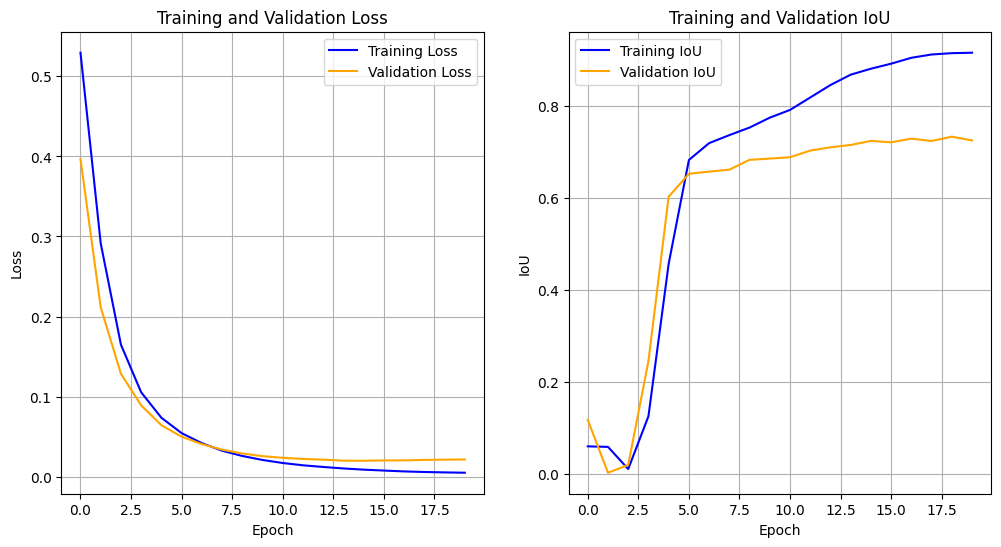

In [22]:
# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_ious, label='Training IoU', color='blue')
plt.plot(val_ious, label='Validation IoU', color='orange')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)
plt.title('Training and Validation IoU')
plt.show()

In [23]:
def predict_and_encode(model, image_path):
    image = load_image(image_path)
    image = neglog_window(image)
    image = torch.from_numpy(image).float().unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

    # path="/kaggle/working/"
    # weights=os.path.join(path , "epoch500-loss0.000312.pth")
    model.eval()
    # model.load_state_dict(torch.load(weights))

    with torch.no_grad():
        output = model(image.to(device))

    binary_pred = (output.cpu().numpy()[0] > 0.5).astype(np.uint8)

    masks = []
    category_ids = []
    fragment_ids = []
    for i in range(30):
        if np.any(binary_pred[i]):
            masks.append(binary_pred[i])
            category_ids.append((i // 10) + 1)
            fragment_ids.append((i % 10) + 1)

    encoded_seg = masks_to_seg(np.array(masks), category_ids, fragment_ids)

    return encoded_seg

In [62]:
image_path = "/root/.cache/kagglehub/datasets/minhchihoang/finalmlmed/versions/1/test/test/Input/071_0000.tif"
image = load_image(image_path)
image = neglog_window(image)
image = np.repeat(image[..., np.newaxis], 3, axis=-1)
image = torch.from_numpy(image).float().permute(2, 0, 1).unsqueeze(0)
print(image.shape)

model.eval()
with torch.no_grad():
        output = model(image.to(device))
print(output.shape)
print(np.unique(output.cpu().numpy()))
check_sigmoid = torch.sigmoid(output)
print(np.unique(check_sigmoid.cpu().numpy()))
binary_pred = (check_sigmoid.cpu().numpy()[0] > 0.5).astype(np.uint8)

binary_pred = (output.cpu().numpy()[0] > 0.5).astype(np.uint8)
masks = []
category_ids = []
fragment_ids = []
for i in range(30):
    if np.any(binary_pred[i]):
        masks.append(binary_pred[i])
        category_ids.append((i // 10) + 1)
        fragment_ids.append((i % 10) + 1)

print(category_ids, fragment_ids)
print(len(masks))


encoded_seg = masks_to_seg(np.array(masks), category_ids, fragment_ids)
print(category_ids)
print(fragment_ids)
print(encoded_seg.shape)
print(type(encoded_seg))
Image.fromarray(encoded_seg).save("/content/predicted_seg_071.tif")


torch.Size([1, 3, 224, 224])
torch.Size([1, 30, 224, 224])
[-12.735379  -12.662566  -12.657108  ...   6.70494     6.7674417
   6.803394 ]
[2.9450575e-06 3.1674954e-06 3.1848303e-06 ... 9.9877661e-01 9.9885070e-01
 9.9889129e-01]
[1, 2, 2, 3] [1, 1, 2, 1]
4
[1, 2, 2, 3]
[1, 1, 2, 1]
(224, 224)
<class 'numpy.ndarray'>


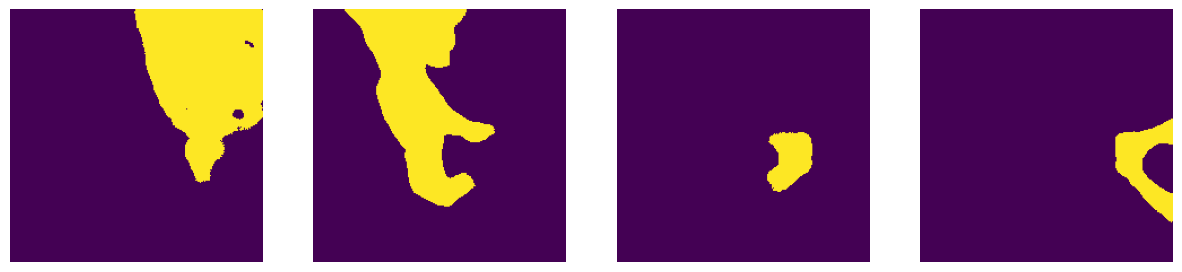

In [63]:
fig, axes = plt.subplots(1, len(masks), figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(masks[i])
    ax.axis("off")
plt.show()

In [65]:
masks, category_ids, fragment_ids = load_masks("/content/predicted_seg_071.tif")
image = load_image(image_path)
output_path = "/content/predict_image_071_resize.png"
predict_image_073 = visualize_sample(image, masks, category_ids, fragment_ids)
predict_image_073_resized = cv2.resize(predict_image_073, (448, 448), interpolation=cv2.INTER_LINEAR)
cv2.imwrite(output_path, predict_image_073_resized)
print(f"Wrote image to {output_path}")

Wrote image to /content/predict_image_071_resize.png
